In [1]:
![ ! -d "fmix" ] && git clone https://github.com/ecs-vlc/fmix

In [2]:
import os
import random
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import wandb
from dataset.affectnet import AffectNetDataset
from dataset.facialexpressions import FacialExpressionsDataset
from dataset.ferplus import FERPlusDataset
from dataset.rafdb import RAFDataset
from fmix_weight import FMix
from imgaug import augmenters as iaa
from layer.mish import MemoryEfficientMish, Mish
from layer.rademacher_dropout import RademacherDropout
from mish_cuda import MishCuda
from model.ab import AccuracyBoosterPlusBlock
from model.resnet import custom_resnet18, custom_resnet50
from model.se import SqueezeExcitationBlock
from optim.lookahead import Lookahead
from optim.lr_scheduler.FlatCosineAnnealing import FlatCosineAnnealing
from optim.radam import RAdam
from sklearn.metrics import accuracy_score, confusion_matrix
from torch import nn, optim
from torch.utils.data import (
    ConcatDataset,
    DataLoader,
    Dataset,
    WeightedRandomSampler,
    random_split,
)
from torchvision import models, transforms
from tqdm.auto import tqdm, trange
from trainer import Trainer

In [3]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.multiprocessing.set_sharing_strategy("file_system")
torch.set_deterministic(True)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
torch.__version__

'1.7.0'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
WORKERS = cpu_count()

BATCH_TARGET = 256
BATCH_SIZE = 64
GRAD_ACC = BATCH_TARGET // BATCH_SIZE

MAX_STEP = 60_000
INFERENCE_BATCH_SIZE = BATCH_SIZE // 4

In [7]:
resize_transform = transforms.Resize(256)
centercrop_transform = transforms.CenterCrop(224)
tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


train_transform = transforms.Compose(
    [
        resize_transform,
        centercrop_transform,
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.25, contrast=0.25, hue=0.05, saturation=0.05
        ),
        np.asarray,
        iaa.Sequential(
            [
                iaa.Affine(rotate=(-15, 15), shear=(-15, 15), mode="symmetric"),
            ]
        ).augment_image,
        tensor_transform,
        normalize_transform,
    ]
)
predict_transform = transforms.Compose(
    [resize_transform, centercrop_transform, tensor_transform, normalize_transform]
)

In [8]:
trainset = ConcatDataset(
    [
        AffectNetDataset("../dataset/AffectNet", "train", transform=train_transform),
        FacialExpressionsDataset(
            "../dataset/facial_expressions", transform=train_transform
        ),
        FERPlusDataset("../dataset/FERPlus", "train", transform=train_transform),
        RAFDataset("../dataset/RAF-DB", "train", transform=train_transform),
    ]
)
len(trainset)

342497

In [9]:
classes = [
    "neutral",
    "happy",
    "surprise",
    "sad",
    "anger",
    "disgust",
    "fear",
    "contempt",
]
classes

['neutral', 'happy', 'surprise', 'sad', 'anger', 'disgust', 'fear', 'contempt']

In [10]:
n_samples = np.zeros(len(classes), dtype=int)

for innerset in trainset.datasets:
    for label in innerset.get_labels():
        n_samples[label] += 1

n_samples

array([ 94645, 152606,  19305,  31289,  28417,   4919,   7389,   3927])

In [11]:
normed_weights = [1 - (x / sum(n_samples)) for x in n_samples]
normed_weights = torch.FloatTensor(normed_weights).to(device)
normed_weights

tensor([0.7237, 0.5544, 0.9436, 0.9086, 0.9170, 0.9856, 0.9784, 0.9885],
       device='cuda:0')

In [12]:
target = [label for innerset in trainset.datasets for label in innerset.get_labels()]
class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1.0 / class_sample_count
samples_weight = weight[target]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [13]:
tensor_weight = torch.as_tensor(weight, dtype=torch.float, device=device)

In [14]:
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    drop_last=True,
    pin_memory=True,
    shuffle=True,
    #     sampler=sampler,
)

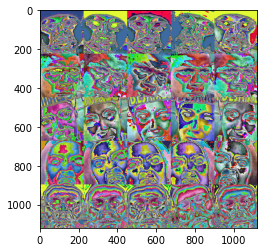

In [15]:
def show_dataset(dataset, n=5):
    pil_transform = transforms.ToPILImage()
    img = np.vstack(
        [
            np.hstack([pil_transform(dataset[i][0]) for _ in range(5)])
            for i in [random.randint(0, len(dataset)) for _ in range(n)]
        ]
    )
    plt.imshow(img)


show_dataset(trainset)

In [16]:
affectnet_valset = AffectNetDataset(
    "../dataset/AffectNet", "val", transform=predict_transform
)
ferplus_valset = FERPlusDataset(
    "../dataset/FERPlus", "val", transform=predict_transform
)
ferplus_testset = FERPlusDataset(
    "../dataset/FERPlus", "test", transform=predict_transform
)
raf_testset = RAFDataset("../dataset/RAF-DB", "test", transform=predict_transform)

In [17]:
valtestset = ConcatDataset(
    [
        affectnet_valset,
        ferplus_valset,
        ferplus_testset,
        raf_testset,
    ]
)
valsize = len(valtestset) // 2
valset, testset = random_split(valtestset, [valsize, len(valtestset) - valsize])

valloader = DataLoader(
    valset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
testloader = DataLoader(
    testset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
len(valset), len(testset)

(7084, 7084)

In [18]:
affectnet_valloader = DataLoader(
    affectnet_valset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
ferplus_valloader = DataLoader(
    ferplus_valset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
ferplus_testloader = DataLoader(
    ferplus_testset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
raf_testloader = DataLoader(
    raf_testset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)

In [19]:
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, len(classes))

In [20]:
# torch.hub.list('zhanghang1989/ResNeSt', force_reload=False)
# model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, len(classes))

In [21]:
model = custom_resnet50(
    activation_layer=MishCuda(),
    #     network_type="preact",
    output_block={
        "class": AccuracyBoosterPlusBlock,
        "params": {},
    },
    #     zero_init_residual=True,
    #     dropblock={"drop_prob": 0.1, "max_steps": MAX_STEP},
    num_classes=len(classes),
)

In [22]:
OUTPUT_PATH = "output/feasible-totem-102.pt"
model.load_state_dict(torch.load(OUTPUT_PATH))

<All keys matched successfully>

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): MishCuda()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_layer): MishCuda()
      (output_block): AccuracyBoosterPlusBlock(
        (pooling_layer): AdaptiveAvg

In [24]:
def predict(model, dataloader, device):
    model = model.to(device)
    model.eval()
    y_pred = []
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)

    return torch.cat(y_pred).cpu().numpy()

In [25]:
# %%timeit
# y_test_pred = predict(model, testloader, device)

In [34]:
# confusion_matrix(
#     np.asarray([target for _, targets in affectnet_valloader for target in targets]),
#     predict(model, affectnet_valloader, device),
#     normalize="true",
# )
confusion_matrix(
    np.asarray([target for _, targets in raf_testloader for target in targets]),
    predict(model, raf_testloader, device),
    normalize="true",
) * 100

array([[86.32352941,  2.05882353,  1.02941176,  8.23529412,  0.29411765,
         1.91176471,  0.14705882],
       [ 2.70042194, 95.18987342,  0.25316456,  0.5907173 ,  0.25316456,
         0.84388186,  0.16877637],
       [ 3.95136778,  1.51975684, 88.75379939,  1.21580547,  1.21580547,
         0.9118541 ,  2.43161094],
       [ 5.23012552,  1.25523013,  0.20920502, 91.42259414,  0.41841004,
         0.83682008,  0.62761506],
       [ 4.32098765,  4.32098765,  0.61728395,  3.08641975, 77.16049383,
         4.9382716 ,  5.55555556],
       [10.        ,  6.875     ,  1.875     , 10.625     ,  5.        ,
        65.        ,  0.625     ],
       [ 4.05405405,  4.05405405,  6.75675676, 10.81081081,  1.35135135,
         4.05405405, 68.91891892]])

In [27]:
y_test_actual = np.asarray([target for _, targets in testloader for target in targets])
y_test_pred = predict(model, testloader, device)

In [28]:
"Test accuracy:", accuracy_score(y_test_actual, y_test_pred)

('Test accuracy:', 0.7673630717108978)

In [29]:
ferplus_y_test_actual = np.asarray(
    [target for _, targets in ferplus_testloader for target in targets]
)
ferplus_y_test_pred = predict(model, ferplus_testloader, device)

In [30]:
"FERPlus Test accuracy:", accuracy_score(ferplus_y_test_actual, ferplus_y_test_pred)

('FERPlus Test accuracy:', 0.8488011283497884)

In [31]:
confusion_matrix(ferplus_y_test_actual, ferplus_y_test_pred, normalize="true")

array([[8.91891892e-01, 2.06677266e-02, 7.94912560e-03, 6.20031797e-02,
        1.19236884e-02, 7.94912560e-04, 2.38473768e-03, 2.38473768e-03],
       [2.58620690e-02, 9.33189655e-01, 1.61637931e-02, 1.18534483e-02,
        1.07758621e-02, 1.07758621e-03, 1.07758621e-03, 0.00000000e+00],
       [6.26398210e-02, 2.90827740e-02, 8.45637584e-01, 4.47427293e-03,
        2.68456376e-02, 0.00000000e+00, 3.13199105e-02, 0.00000000e+00],
       [2.15246637e-01, 1.79372197e-02, 2.24215247e-03, 7.04035874e-01,
        3.81165919e-02, 8.96860987e-03, 1.34529148e-02, 0.00000000e+00],
       [9.65732087e-02, 3.42679128e-02, 9.34579439e-03, 4.04984424e-02,
        7.97507788e-01, 1.55763240e-02, 6.23052960e-03, 0.00000000e+00],
       [1.00000000e-01, 1.00000000e-01, 5.00000000e-02, 5.00000000e-02,
        2.00000000e-01, 5.00000000e-01, 0.00000000e+00, 0.00000000e+00],
       [7.21649485e-02, 0.00000000e+00, 2.78350515e-01, 8.24742268e-02,
        5.15463918e-02, 0.00000000e+00, 5.15463918e-01, 0.

In [32]:
raf_y_test_actual = np.asarray(
    [target for _, targets in raf_testloader for target in targets]
)
raf_y_test_pred = predict(model, raf_testloader, device)

In [33]:
"RAF-DB Test accuracy:", accuracy_score(raf_y_test_actual, raf_y_test_pred)

('RAF-DB Test accuracy:', 0.8878748370273793)